<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" />
    
    
### <font color='navy'> Modelos no lineales para pronósticos.

**Nombres:** Francisco Javier Gonzalez Lazalde.

**Fecha:** 15 de octubre del 2025.

**Expediente** : 744576.
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/MPST-2025-I/tarea-4-ejercicio-cnn-tarea-4-2.git

# Tarea 4: Clase 13

1. Buscar un artículo científico donde se apliquen las CNN. Hacer una discusión y mostrar los resultados en el notebook de solución de la tarea. (Sólo se va solicitar un artículo por pareja)

2. Implementar todas las técnicas vistas en esta clase al siguiente dataset para predecir el precio de las viviendas:

* https://www.kaggle.com/datasets/yasserh/housing-prices-dataset. El objetivo en este ejercicio es que usen una CNN para predecir el precio de las casas. Este dataset, ya tiene todas las características a ser usadas por el modelo, así que no tienen que realizar alguna preparación especial de los datos. Sólo buscar la mejor estructura de la CNN que les de mejores resultados.

* https://www.kaggle.com/datasets/joebeachcapital/nsw-australia-electricity-demand-2018-2023/data. Por el contrario en este dataset ya se proporciona una serie temporal, donde el objetivo es predecir el consumo de demnada eléctrico en Australia. Con esta serie temporal, si pueden aplicar las funciones de preparación de datos para CNN como se vió en clase.

# Artículo Científico

https://www.redalyc.org/journal/3442/344264813015/344264813015.pdf

Un ejemplo destacado de la aplicación de Redes Neuronales Convolucionales (CNN) en el ámbito biomédico es el artículo titulado "Redes neuronales convolucionales para la clasificación de componentes independientes de imágenes de resonancia magnética funcional en estado de reposo".

## Resumen del Artículo
Este estudio propone una estrategia innovadora para la clasificación automática de componentes independientes obtenidas de imágenes de resonancia magnética funcional (fMRI) en estado de reposo. La metodología consta de dos etapas principales:​

###Reducción de Volúmenes
Se aplicaron dos métodos de reducción para transformar los volúmenes tridimensionales de las componentes independientes en imágenes bidimensionales, preservando las características espaciales esenciales.​

###Clasificación con CNN
Se diseñaron seis modelos de CNN para clasificar las imágenes resultantes en componentes asociadas a ruido o a actividad neuronal relevante.​

##Resultados Destacados
###Precisión de Clasificación
Las redes neuronales convolucionales alcanzaron precisiones superiores al 98% en la discriminación de componentes independientes asociadas a ruido y actividad neuronal.​

###Comparativa con Otros Métodos
La combinación de los métodos de reducción de volúmenes con las CNN superó en precisión a los métodos de machine learning convencionales.​
Redalyc

##Discusión
La investigación demuestra que las CNN, combinadas con técnicas adecuadas de preprocesamiento, pueden mejorar significativamente la clasificación de componentes independientes en fMRI. Esto es crucial para la identificación precisa de patrones de actividad cerebral y la eliminación de artefactos, lo que puede contribuir al avance en el diagnóstico y tratamiento de diversas patologías neurológicas.​

Código de solución Francisco

In [1]:
# Paqueterías necesarias
import os
import zipfile
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv("Housing.csv")
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
binary_cols = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea"]
for col in binary_cols:
    df[col] = df[col].map({'yes': 1, 'no': 0})

df["furnishingstatus"] = LabelEncoder().fit_transform(df["furnishingstatus"])

df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0


In [5]:
X = df.drop(columns=["price"]).values
y = df["price"].values

In [6]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_x.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1))

In [7]:
n_steps = 3
n_features = X.shape[1]

In [8]:
X_seq, y_seq = [], []
for i in range(len(X) - n_steps):
    X_seq.append(X[i:i + n_steps])
    y_seq.append(y[i + n_steps])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [10]:
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(optimizer='adam', loss='mse')

In [12]:
history = model.fit(X_train, y_train, epochs=1000, verbose=0, validation_data=(X_test, y_test))

In [13]:
loss = model.evaluate(X_test, y_test)
print(f'Error cuadrático medio en test: {loss}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035
Error cuadrático medio en test: 0.003380227368324995


In [14]:
predicciones = model.predict(X_test)
predicciones = scaler_y.inverse_transform(predicciones)
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

print("Predicciones de precios:", predicciones.flatten())

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicciones de precios: [ 3544776.8  4633334.   4258492.   6509523.   5143487.5  7128133.
  5408194.   3038298.   1783640.9  3289986.2  9815416.   5214104.
  3985813.2  7564320.5  2750686.   4794442.5  2905928.2  6369255.
  2459594.8  6493059.5  5208579.5  3701900.8  5906064.   4853415.
  2920345.5  8560361.   5345446.   4001701.   8406849.   5869943.5
  5720502.   5200789.5  4987384.5  3631772.5  2555569.2  3333982.2
  2709532.   5736085.   4674895.5  2481818.2  3150608.8  4918093.5
  4753821.   5857170.   5401811.   6193229.5  4646601.   4191071.5
  4639561.   7088996.   3231160.2  2375037.8  2509967.2  9509773.
  2977800.8  5497260.   5573501.   2239042.5  4528937.5  3805543.2
  4513254.5  4217381.   6764921.   2356747.5  7395564.5  3295344.5
  3716865.8  4118866.8  4079759.8  4057537.   7237574.   5344134.
  5511056.   5324869.5  6989834.   2955289.   7822063.5  4950398.
  3968884.8  7483370.   5044006.   7193002.5  6449606.   4849271.5
 10000

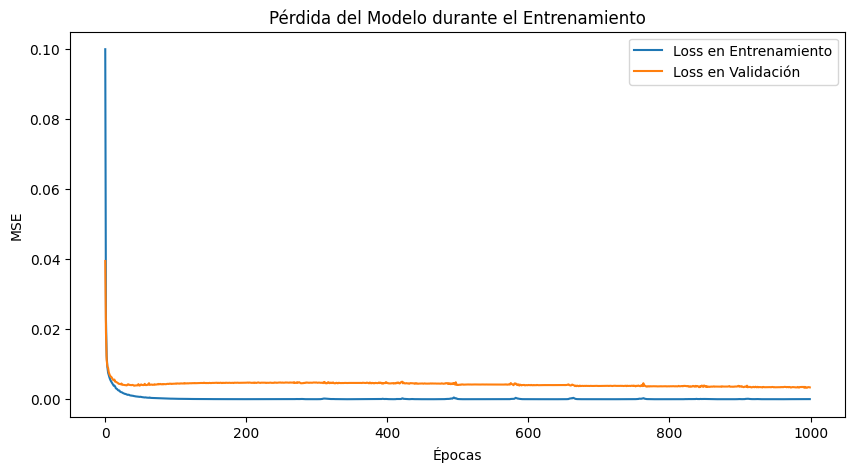

In [15]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Loss en Entrenamiento')
plt.plot(history.history['val_loss'], label='Loss en Validación')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.title('Pérdida del Modelo durante el Entrenamiento')
plt.legend()
plt.show()

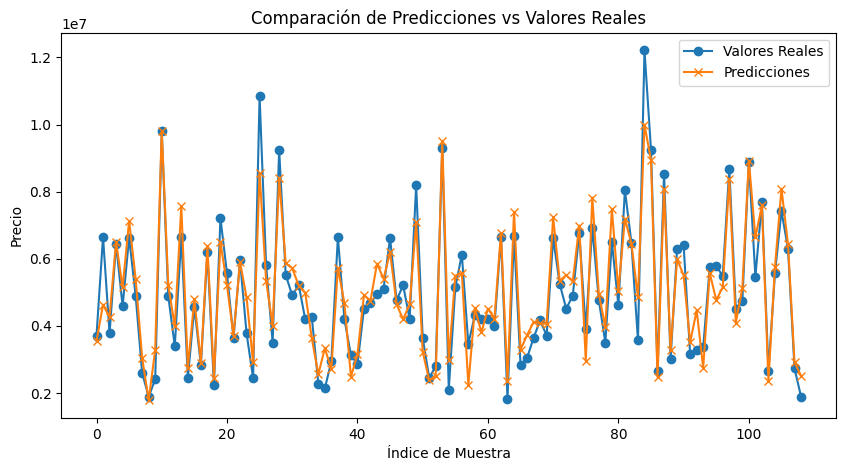

In [16]:
plt.figure(figsize=(10,5))
plt.plot(y_test_original, label='Valores Reales', marker='o')
plt.plot(predicciones, label='Predicciones', marker='x')
plt.xlabel('Índice de Muestra')
plt.ylabel('Precio')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.legend()
plt.show()

In [17]:
zip_path = "AED.zip"

dataframes = []
with zipfile.ZipFile(zip_path, "r") as z:
    for file_name in z.namelist():
        if file_name.endswith(".csv"):
            with z.open(file_name) as file:
                df = pd.read_csv(file)
                dataframes.append(df)

In [18]:
df = pd.concat(dataframes, ignore_index=True)

In [19]:
df = df.sort_values(by="SETTLEMENTDATE")

In [20]:
df = df[["SETTLEMENTDATE", "TOTALDEMAND", "RRP"]]

In [21]:
df.head()

,SETTLEMENTDATE,TOTALDEMAND,RRP
0,2018/01/01 00:30:00,6912.25,91.86
1,2018/01/01 01:00:00,6745.63,88.83
2,2018/01/01 01:30:00,6466.06,73.62
3,2018/01/01 02:00:00,6279.80,71.49
4,2018/01/01 02:30:00,6177.31,69.27


In [22]:
scaler = MinMaxScaler()
df[["TOTALDEMAND", "RRP"]] = scaler.fit_transform(df[["TOTALDEMAND", "RRP"]])

In [23]:
def split_multivariate_sequence(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(data):
            break
        seq_x, seq_y = data[i:end_ix, :-1], data[end_ix:out_end_ix, -1]  # -1 es TOTALDEMAND
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [24]:
dataset = df[["TOTALDEMAND", "RRP"]].values

In [25]:
n_steps_in = 3
n_steps_out = 2

In [26]:
X, y = split_multivariate_sequence(dataset, n_steps_in, n_steps_out)

In [27]:
n_features = X.shape[2]

model = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)),
    MaxPooling1D(),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(n_steps_out)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(X, y, epochs=100, verbose=1, validation_split=0.1)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6992/6992 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 2.6157e-04 - val_loss: 6.7806e-04
Epoch 2/100
6992/6992 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 2.6039e-04 - val_loss: 6.7894e-04
Epoch 3/100
6992/6992 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 2.4786e-04 - val_loss: 6.7676e-04
Epoch 4/100
6992/6992 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 2.7576e-04 - val_loss: 6.8993e-04
Epoch 5/100
6992/6992 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 2.6638e-04 - val_loss: 6.7785e-04
Epoch 6/100
6992/6992 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 2.5549e-04 - val_loss: 6.7675e-04
Epoch 7/100
6992/6992 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 2.7296e-04 - val_loss: 6.7753e-04
Epoch 8/100
6992/6992 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 2.9449e-04 - val_loss: 6.7714e-04
Epoch 9/100
6992/6992 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 2.1677e-04 - val_loss: 6.7642e-04
Epoch 10/100
6992/6992 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 2.2476e-04 - val_loss: 6.8485e-04
Epoch 11/100
6992/6992 ━━━━━━━━

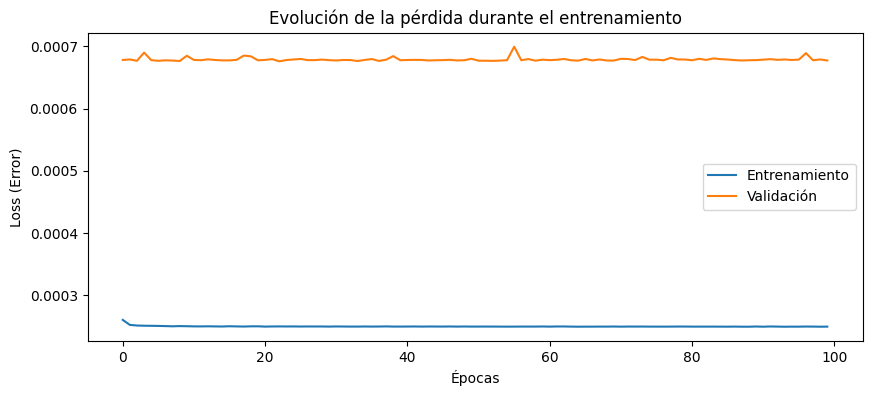

In [28]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Loss (Error)')
plt.legend()
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.show()

Código de solución estudiante 2

In [ ]:
# Código de solución estudiante 2
.
.
.
.


### Respuesta planteada en el ejercicio usando (markdown)
 La respuesta es .........